# Handicapping pub trivia

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# If we're running in Colab, install empiricaldist

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

### Introduction

This notebook is inspired by [this question on Reddit's statistics forum](https://www.reddit.com/r/statistics/comments/e7bqbr/q_normalize_trivia_results_with_different_team/)

> If there is a quiz of `x` questions with varying results between teams of different sizes, how could you logically handicap the larger teams to bring some sort of equivalence in performance measure?

> [Suppose there are] 25 questions and a team of two scores 11/25. A team of 4 scores 17/25. Who did better in terms of average performance of each member?

One respondent suggested a binomial model, in which every player has the same probability of answering any question correctly.

I suggested a model based on item response theory, in which each question has a different level of difficulty, `d`, each player has a different level of efficacy `e`, and the probability that a player answers a question is

```
expit(e-d+c)
```

where `c` is a constant offset for all players and questions, and `expit` is the inverse of the logit function.

Another respondent pointed out that group dynamics will come into play.  On a given team, it is not enough if one player knows the answer; they also have to persuade their teammates.

So let's explore these models and see how far we get.  Among other things, this will be a good exercise in using NumPy n-dimensional arrays.

### The binomial model

I'll start with an array with dimensions for `k` players, `n` questions, and `m=1000` simulations.

In [2]:
import numpy as np

k = 4      # number of players
n = 25     # number of questions
m = 10000   # number of iterations

a = np.random.random((k, n, m))
a.shape

(4, 25, 10000)

Now suppose each player has a 30% chance of answer each question.  We can compute a Boolean array that indicates which questions each player got.

In [3]:
p = 0.3

b = (a < p)
b.shape

(4, 25, 10000)

Let's assume for now that a team gets the question right if any of the players gets it.

If you like, you can think of "gets it" as a combination of "knows the answer" and "successfuly convinces teammates".

With this assumption, we can use the logical OR operator to reduce the answers along the player axis.

In [4]:
c = np.logical_or.reduce(b, axis=0)
c.shape

(25, 10000)

The result is an array with one dimension for questions and one for iterations.

Now we can compute the sum along the questions.

In [5]:
d = np.sum(c, axis=0)
d.shape

(10000,)

The result is one-dimensional array of iterations that approximates the distribution of scores for a team of `k=4` players.

Here's what the distribution looks like.

In [6]:
from empiricaldist import Cdf

In [7]:
import matplotlib.pyplot as plt

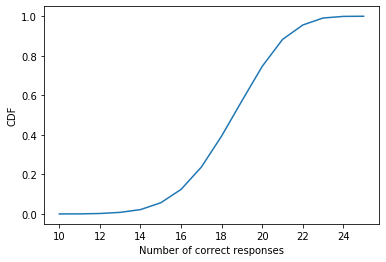

In [8]:
cdf = Cdf.from_seq(d)
cdf.plot()

plt.xlabel('Number of correct responses')
plt.ylabel('CDF');

The following function encapsulates the code we have so far, so we can run it with different values of `k`:

In [9]:
def simulate(p, k, n=25, m=10000):
    a = np.random.random((k, n, m))
    b = (a < p)
    c = np.logical_or.reduce(b, axis=0)
    d = np.sum(c, axis=0)
    return d

Here's what the distribution of correct responses looks like for a range of values of `k`.

7.0
13.0
16.0
19.0
21.0


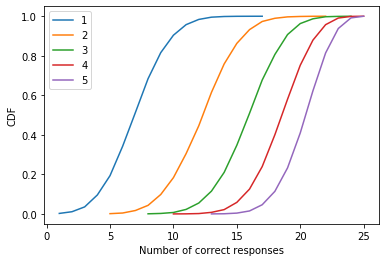

In [10]:
p = 0.3

for k in range(1, 6):
    d = simulate(p, k)
    cdf = Cdf.from_seq(d)
    cdf.plot(label=k)
    print(cdf.median())

plt.xlabel('Number of correct responses')
plt.ylabel('CDF');
plt.legend();

We can use these CDFs to compare scores between teams with different sizes.

A team of two that scores 11/25 is in the 31nd percentile. 

In [11]:
d = simulate(p=0.3, k=2)
cdf = Cdf.from_seq(d)
cdf(11)

array(0.309)

A team of 4 that scores 17/25 is in the 22nd percentile.

In [12]:
d = simulate(p=0.3, k=4)
cdf = Cdf.from_seq(d)
cdf(17)

array(0.2415)

So I would say the team of two out-performed the team of 4.

### Item response theory

Now suppose we have players with different levels of efficacy, drawn from a standard normal distribution.

In [13]:
players = np.random.normal(size=(k, 1, m))
players.shape

(5, 1, 10000)

And questions with different levels of difficulty, also drawn from a standard normal distribution.

In [14]:
questions = np.random.normal(size=(1, n, m))
questions.shape

(1, 25, 10000)

We can use the `expit` function to compute the probability that each player answers each question.

In [15]:
from scipy.special import expit

c = -1
p = expit(players - questions + c)
p.shape

(5, 25, 10000)

I chose `c=-1` so that the average probability is about the same as in the binomial model.

In [16]:
np.mean(p)

0.3237610597780847

We can use the same `simulate` function with the new model; the difference is that `p` is an array now, rather than a constant.

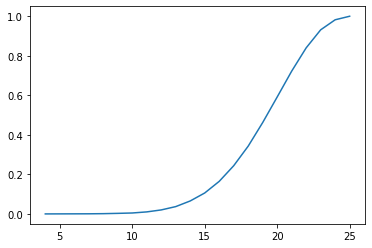

In [17]:
d = simulate(p, k)
cdf = Cdf.from_seq(d)
cdf.plot()

Here are the distributions with a range of values for `k`:

8.0
13.0
16.0
18.0
20.0


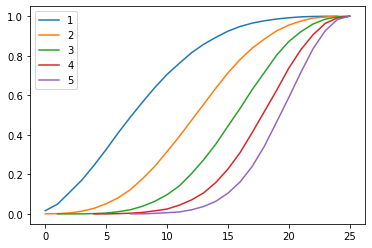

In [18]:
questions = np.random.normal(size=(1, n, m))

for k in range(1, 6):
    players = np.random.normal(size=(k, 1, m))
    p = expit(players - questions + c)
    d = simulate(p, k)
    cdf = Cdf.from_seq(d)
    cdf.plot(label=k)
    print(cdf.median())
    
plt.legend();

Again, we can use these CDFs to compare scores between teams with different sizes.

A team of two that scores 11/25 is in the 39th percentile. 

In [19]:
k = 2
players = np.random.normal(size=(k, 1, m))
p = expit(players - questions + c)
d = simulate(p, k)
cdf = Cdf.from_seq(d)
cdf(11)

array(0.3921)

A team of 4 that scores 17/25 is in the 40th percentile.

In [20]:
k = 4
players = np.random.normal(size=(k, 1, m))
p = expit(players - questions + c)
d = simulate(p, k)
cdf = Cdf.from_seq(d)
cdf(17)

array(0.4097)

So under this model we would say the team of 4 out-performed the team of 2, which is the opposite of our conclusion under the multinomial model!